# **Tarea: Cross Entropy**

## Alumno: José de Jesús Hernández Higuera

### Matrícula: 224470489

Instrucciones:

- Configura el entorno:
Usa gymnasium.make("CartPole-v1").

- Representación de la política:

Usa una red neuronal simple (ej. torch.nn.Sequential) que reciba el estado y devuelva probabilidades de acciones (0: izquierda, 1: derecha).

- Inicializa los parámetros de la política de forma aleatoria.

Implementa la técnica CEM:
En cada iteración:

- Genera un conjunto de episodios (N=50).

- Evalúa las recompensas totales.

- Selecciona el percentil top (ej. 70%) de episodios con mayor recompensa.

Ajusta los parámetros de la política usando los datos de los mejores episodios.

Criterio de convergencia:

- Termina el entrenamiento cuando el promedio de recompensas de los mejores episodios supere un umbral (ej. 450 puntos en CartPole).

Entrega esperada:

- Código en Python que entrene al agente.

- Gráfica de la recompensa promedio por iteración.

Iter 0: mean reward = 23.16, threshold = 26.00
Iter 1: mean reward = 25.84, threshold = 28.00
Iter 2: mean reward = 28.50, threshold = 32.90
Iter 3: mean reward = 30.98, threshold = 33.00
Iter 4: mean reward = 26.54, threshold = 33.00
Iter 5: mean reward = 27.08, threshold = 29.60
Iter 6: mean reward = 28.94, threshold = 34.30
Iter 7: mean reward = 32.82, threshold = 38.30
Iter 8: mean reward = 37.22, threshold = 41.60
Iter 9: mean reward = 37.74, threshold = 43.30
Iter 10: mean reward = 39.68, threshold = 46.00
Iter 11: mean reward = 39.38, threshold = 51.30
Iter 12: mean reward = 41.74, threshold = 50.60
Iter 13: mean reward = 43.00, threshold = 47.30
Iter 14: mean reward = 50.42, threshold = 58.20
Iter 15: mean reward = 44.86, threshold = 49.60
Iter 16: mean reward = 58.44, threshold = 68.30
Iter 17: mean reward = 58.00, threshold = 58.50
Iter 18: mean reward = 60.34, threshold = 65.30
Iter 19: mean reward = 55.02, threshold = 61.90
Iter 20: mean reward = 52.94, threshold = 59.50
It

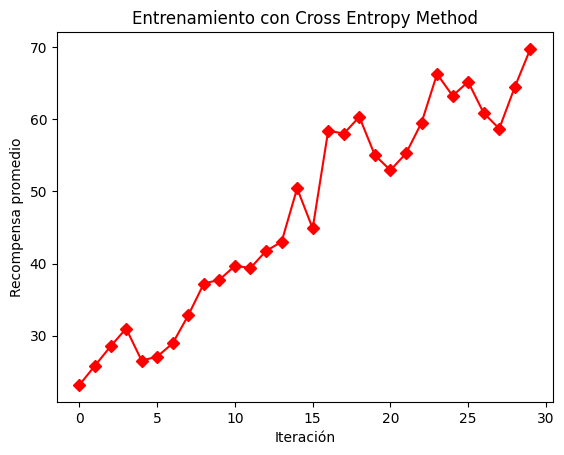

In [2]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 1. Crear el entorno
env = gym.make("CartPole-v1")

# 2. Definir política (MLP simple)
class Policy(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 32),
            nn.ReLU(),
            nn.Linear(32, action_dim),
            nn.Softmax(dim=-1)
        )
    def forward(self, x):
        return self.net(x)

# Inicializar política y optimizador
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
policy = Policy(state_dim, action_dim)
optimizer = optim.Adam(policy.parameters(), lr=0.01)

# -------- FUNCIÓN PARA GENERAR EPISODIOS ----------
def generate_episode(policy, env):
    states, actions, rewards = [], [], []
    obs, _ = env.reset()
    done = False
    while not done:
        state_t = torch.tensor(obs, dtype=torch.float32)
        probs = policy(state_t)   # TODO: pasar el estado
        action = torch.distributions.Categorical(probs).sample().item()  # TODO: usar las probabilidades
        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        states.append(obs)
        actions.append(action)   # TODO: guardar la acción
        rewards.append(reward)   # TODO: guardar la recompensa
        obs = next_obs
    return states, actions, sum(rewards)

# --------- CROSS ENTROPY METHOD -----------
N = 50          # episodios por iteración
percentile = 70 # selección de élite
n_iterations = 30
reward_history = []

for iteration in range(n_iterations):
    batch = [generate_episode(policy, env) for _ in range(N)]
    rewards = [episode[2] for episode in batch]
    reward_threshold = np.percentile(rewards, percentile)  # TODO: usar el percentil

    # seleccionar elite
    elite_states = []
    elite_actions = []
    for states, actions, total_r in batch:
        if total_r >= reward_threshold:   # TODO: aplicar el umbral
            elite_states.extend(states)
            elite_actions.extend(actions)

    # convertir a tensores
    elite_states_t = torch.tensor(elite_states, dtype=torch.float32)
    elite_actions_t = torch.tensor(elite_actions, dtype=torch.int64)

    # actualizar política
    optimizer.zero_grad()
    logits = policy(elite_states_t)  # TODO: pasar los estados elite
    loss = nn.CrossEntropyLoss()(logits, elite_actions_t)  # TODO: usar acciones elite
    loss.backward()
    optimizer.step()

    mean_reward = np.mean(rewards)
    reward_history.append(mean_reward)
    print(f"Iter {iteration}: mean reward = {mean_reward:.2f}, threshold = {reward_threshold:.2f}")

# --------- GRAFICAR -----------
plt.plot(reward_history, color='red', marker='D')
plt.xlabel("Iteración")
plt.ylabel("Recompensa promedio")
plt.title("Entrenamiento con Cross Entropy Method")
plt.show()
